# Mixture density network for regression tasks

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np 
import matplotlib.pyplot as plt
from util import get_data4mdn,tf_normal,kron,invkronprod
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print ("Packages loaded")

Packages loaded


Generate data for training mixture density network

xdata.shape:  (1000, 1)
ydata.shape:  (1000, 2)


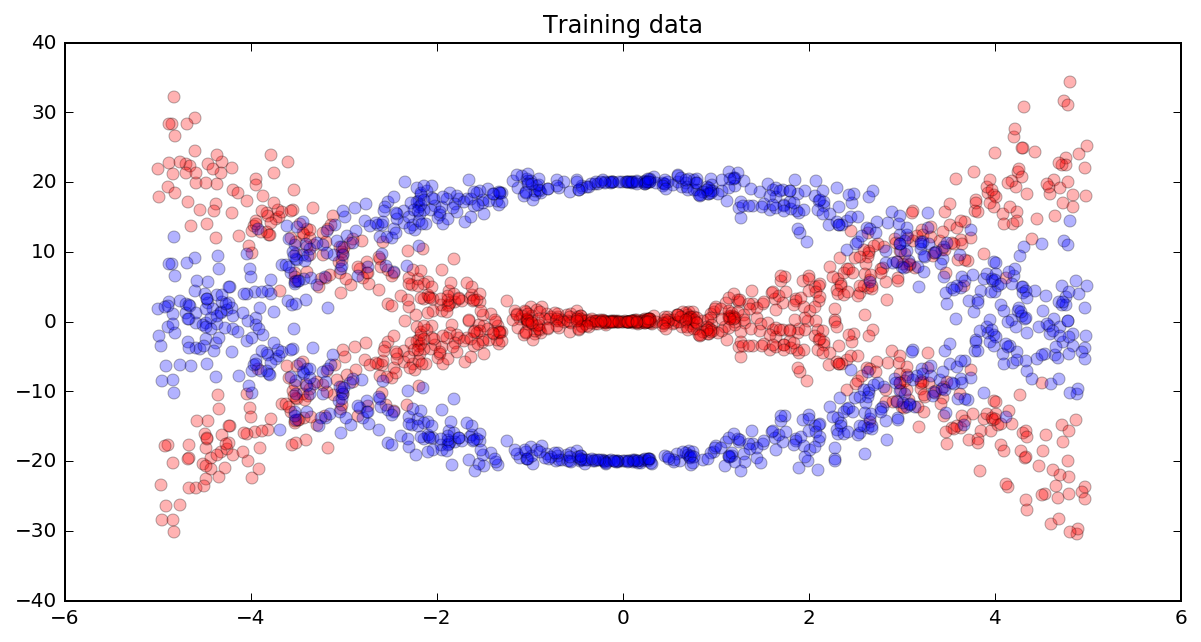

In [2]:
""" Get Data """
xdata,_ydata,_zdata = get_data4mdn(_xmin=-5.,_xmax=5.,_bias=20,_nsample=1e3)
ydata = np.concatenate((_ydata,_zdata),axis=1)
""" Print """
print 'xdata.shape: ',xdata.shape
print 'ydata.shape: ',ydata.shape
""" Plot """
plt.figure(figsize=(10,5))
plt.plot(xdata,ydata[:,0],'ro',alpha=0.3)
plt.plot(xdata,ydata[:,1],'bo',alpha=0.3)
plt.title('Training data')
plt.show()

Mixture Density Network Class

In [3]:
class basic_mdn(object):
    def __init__(self,_name='',_xdim=1,_ydim=1,_hdim=64,_kmix=10
                 ,_actv=tf.nn.relu,_bn=slim.batch_norm
                 ,_sigmax=5):
        self.name = _name
        self.xdim = _xdim
        self.ydim = _ydim
        self.hdim = _hdim
        self.kmix = _kmix
        self.actv = _actv 
        self.bn   = _bn
        self.sigmax = _sigmax
        """ Build model """
        self.build_model()
        """ Build graph """
        self.build_graph()
        
        """ Print """
        print ("[%s] instantiated" %(self.name))
        print (" xdim:[%d],ydim:[%d]"%(self.xdim,self.ydim))
        print ("Trainable Variables")
        for i in range(len(self.t_vars)):
            w_name  = self.t_vars[i].name
            w_shape = self.t_vars[i].get_shape().as_list()
            print (" [%02d] Name:[%s] Shape:[%s]" % (i,w_name,w_shape))
        print ("Global Variables")
        for i in range(len(self.g_vars)):
            w_name  = self.g_vars[i].name
            w_shape = self.g_vars[i].get_shape().as_list()
            print (" [%02d] Name:[%s] Shape:[%s]" % (i,w_name,w_shape))
        
    """
        Build model
    """
    def build_model(self):
        self.x  = tf.placeholder(dtype=tf.float32,shape=[None,self.xdim])
        self.y  = tf.placeholder(dtype=tf.float32,shape=[None,self.ydim])
        self.kp = tf.placeholder(dtype=tf.float32,shape=[])
        self.lr = tf.placeholder(dtype=tf.float32,shape=[])
        self.wdrate = tf.placeholder(dtype=tf.float32,shape=[])
        self.is_training = tf.placeholder(dtype=tf.bool,shape=[])
        self.fully_init  = tf.random_normal_initializer(stddev=0.01)
        self.bias_init   = tf.constant_initializer(0.)
        self.bn_init     = {'beta': tf.constant_initializer(0.),
                           'gamma': tf.random_normal_initializer(1., 0.02)}
        self.bn_params   = {'is_training':self.is_training,'decay':0.9,'epsilon':1e-5,
                           'param_initializers':self.bn_init,'updates_collections': None}
        with tf.variable_scope('W',reuse=False) as scope:
            with slim.arg_scope([slim.fully_connected],
                                activation_fn=self.actv,
                                weights_initializer=self.fully_init,
                                biases_initializer=self.bias_init,
                                normalizer_fn=self.bn,
                                normalizer_params=self.bn_params,
                                weights_regularizer=slim.l2_regularizer(self.wdrate)):
                _net = slim.fully_connected(self.x,self.hdim,scope='lin0')
                """ NOTE: Always dropout! modify keep probability """
                _net = slim.dropout(_net,keep_prob=self.kp,is_training=True,scope='dr0')  
                _net = slim.fully_connected(_net,self.hdim,scope='lin1')
                _net = slim.dropout(_net,keep_prob=self.kp,is_training=True,scope='dr1')  
                """ Mixture Density Network """ 
                _pi_hat    = slim.fully_connected(_net,self.kmix,scope='pi_hat')
                _mu        = slim.fully_connected(_net,self.kmix*self.ydim,scope='mu')
                _sigma_hat = slim.fully_connected(_net,self.kmix*self.ydim,scope='sigma')
                _pi        = tf.nn.softmax(_pi_hat,dim=1)
                _sigma     = self.sigmax*tf.nn.sigmoid(_sigma_hat)
                self.pi    = _pi
                self.mu    = _mu
                self.sigma = _sigma
        """ Get variables """
        _g_vars = tf.global_variables()
        self.g_vars = [var for var in _g_vars if 'W/' in var.name]
        _t_vars = tf.trainable_variables()
        self.t_vars = [var for var in _t_vars if 'W/' in var.name]
    
    """
        Build Graph
    """
    def build_graph(self):
        """ Likelihood of a gaussian mixture model """
        self.probs_raw = tf_normal(_y=tf.tile(self.y,[1,self.kmix]),_mu=self.mu,_sigma=self.sigma)
        # self.probs_raw: [-1,self.ydim*self.kmix]
        self.probs = invkronprod(self.probs_raw,_k=self.ydim)
        # self.probs: [-1,self.kmix]
        _h = tf.shape(self.pi)[0]
        self.gmm_prob = tf.reduce_sum(self.probs*tf.tile(self.pi,[_h,1]),axis=1)
        # self.probs: [-1,1]
        _eps = 1e-9
        self.gmm_nll  = tf.reduce_mean(-tf.log(self.gmm_prob+_eps))
        # self.gmm_nll: []
        """ Loss and optimizer """
        self.loss = self.gmm_nll + sum(tf.losses.get_regularization_losses())
        self.optm = tf.train.AdamOptimizer(learning_rate=self.lr
            , beta1=0.9, beta2=0.999, epsilon=0.01).minimize(self.loss)
    """ 
        Sampler 
    """
    def sampler(self,_sess,_x,_k):
        self.x = _x
        
        
        
        
        
        
print ("Class ready")        

Class ready


Instantiate MDN Class

In [4]:
M = basic_mdn(_name='MDN',_xdim=1,_ydim=2,_hdim=64,_kmix=10,_actv=tf.nn.relu,_bn=slim.batch_norm)

[MDN] instantiated
 xdim:[1],ydim:[2]
Trainable Variables
 [00] Name:[W/lin0/weights:0] Shape:[[1, 64]]
 [01] Name:[W/lin0/BatchNorm/beta:0] Shape:[[64]]
 [02] Name:[W/lin1/weights:0] Shape:[[64, 64]]
 [03] Name:[W/lin1/BatchNorm/beta:0] Shape:[[64]]
 [04] Name:[W/pi_hat/weights:0] Shape:[[64, 10]]
 [05] Name:[W/pi_hat/BatchNorm/beta:0] Shape:[[10]]
 [06] Name:[W/mu/weights:0] Shape:[[64, 20]]
 [07] Name:[W/mu/BatchNorm/beta:0] Shape:[[20]]
 [08] Name:[W/sigma/weights:0] Shape:[[64, 20]]
 [09] Name:[W/sigma/BatchNorm/beta:0] Shape:[[20]]
Global Variables
 [00] Name:[W/lin0/weights:0] Shape:[[1, 64]]
 [01] Name:[W/lin0/BatchNorm/beta:0] Shape:[[64]]
 [02] Name:[W/lin0/BatchNorm/moving_mean:0] Shape:[[64]]
 [03] Name:[W/lin0/BatchNorm/moving_variance:0] Shape:[[64]]
 [04] Name:[W/lin1/weights:0] Shape:[[64, 64]]
 [05] Name:[W/lin1/BatchNorm/beta:0] Shape:[[64]]
 [06] Name:[W/lin1/BatchNorm/moving_mean:0] Shape:[[64]]
 [07] Name:[W/lin1/BatchNorm/moving_variance:0] Shape:[[64]]
 [08] Name